### Import data from SQL database

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, password =sqluser )
cur = con.cursor()

In [3]:
# psql "dbname=mimic user=postgres"
# \i all_data.sql 

# SQL query (gets all_data view defined elsewhere)
query = \
"""
select * from all_data
"""

# Perform SQL query
cur.execute('SET search_path to ' + schema_name)
data = pd.read_sql_query(query,con)

# Preliminary statistics

In [44]:
data.to_csv('data.csv',index=False)

In [ ]:
data.shape

In [5]:
print ('Number of unique patient ids: {}'.format(len(data.subject_id.unique())))

Number of unique patient ids: 34005


In [6]:
print ('age\n',data.age.describe().ix[['mean', 'std']],'\n')
print ('age (<300)\n', data.loc[data.age<300].age.describe().ix[['mean', 'std']], '\n')
print ('sapsii\n', data.sapsii.describe().ix[['mean', 'std']],'\n')
print ('sofa\n', data.sofa.describe().ix[['mean', 'std']],'\n')
print (data[['urea_n_min','urea_n_mean','urea_n_max',]].describe().ix[['mean', 'std']],'\n')
print (data[['urea_n_min','urea_n_mean','urea_n_max',]].describe().ix[['mean', 'std']], '\n')
print (data[['magnesium_max','albumin_min','calcium_min']].describe().ix[['mean', 'std']], '\n')
print (data[['resprate_min','resprate_mean','resprate_max']].describe().ix[['mean', 'std']], '\n')
print (data[['glucose_min','glucose_mean','glucose_max']].describe().ix[['mean', 'std']], '\n')
print (data[['hr_min','hr_mean','hr_max']].describe().ix[['mean', 'std']], '\n')
print (data[['sysbp_min','sysbp_mean','sysbp_max']].describe().ix[['mean', 'std']], '\n')
print (data[['diasbp_min','diasbp_mean','diasbp_max']].describe().ix[['mean', 'std']], '\n')
print (data[['temp_min','temp_mean','temp_max']].describe().ix[['mean', 'std']], '\n')
print (data[['urine_min','urine_mean','urine_max']].describe().ix[['mean', 'std']])

C:\Users\64877\Anaconda3\envs\DS_final\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\64877\Anaconda3\envs\DS_final\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\64877\Anaconda3\envs\DS_final\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from

age
 mean    75.415010
std     53.924155
Name: age, dtype: float64 

age (<300)
 mean    63.580520
std     16.022694
Name: age, dtype: float64 

sapsii
 mean    36.797400
std     14.494745
Name: sapsii, dtype: float64 

sofa
 mean    4.556797
std     3.241760
Name: sofa, dtype: float64 

      urea_n_min  urea_n_mean  urea_n_max
mean   16.463710    27.333612   42.224557
std    13.314368    18.915366   31.176981 

      urea_n_min  urea_n_mean  urea_n_max
mean   16.463710    27.333612   42.224557
std    13.314368    18.915366   31.176981 

      magnesium_max  albumin_min  calcium_min
mean       2.501767     2.799359     7.673363
std        1.012201     0.757489     0.863674 

      resprate_min  resprate_mean  resprate_max
mean      9.782119      19.375751     32.962557
std       3.727347       3.539746      9.072195 

      glucose_min  glucose_mean  glucose_max
mean    86.977461    137.750363   271.053735
std     30.178478     86.866399  5961.165184 

         hr_min    hr_mean      

C:\Users\64877\Anaconda3\envs\DS_final\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
C:\Users\64877\Anaconda3\envs\DS_final\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
C:\Users\64877\Anaconda3\envs\DS_final\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-de

Text(0, 0.5, '')

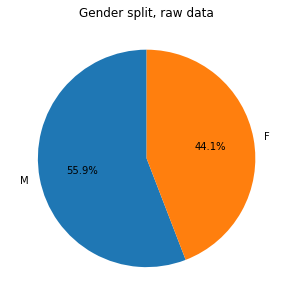

In [8]:
fig = plt.figure(figsize=(5,5))
data.gender.value_counts().plot.pie(startangle = 90, autopct='%1.1f%%')
plt.title('Gender split, raw data')
plt.ylabel('')
# plt.savefig('figures/raw_gender.png')

Text(0, 0.5, '')

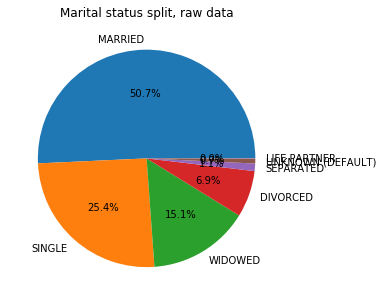

In [9]:
fig = plt.figure(figsize=(5,5))
data.marital_status.value_counts().plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Marital status split, raw data')
plt.ylabel('')
# fig.savefig('figures/raw_marital.png')

Text(0, 0.5, '')

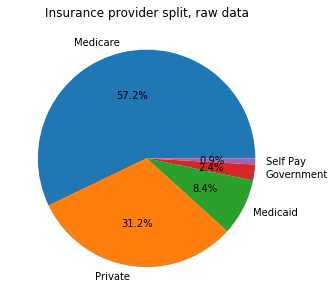

In [10]:
fig = plt.figure(figsize=(5,5))
data.insurance.value_counts().plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Insurance provider split, raw data')
plt.ylabel('')
# fig.savefig('figures/raw_insurance.png')

In [11]:
np.sum(data.isnull())

subject_id            0
hadm_id               0
admittime             0
dischtime             0
deathtime         48877
first_careunit        0
last_careunit         0
age                   0
gender                0
marital_status     2826
insurance             0
urea_n_min           33
urea_n_max           33
urea_n_mean          33
platelets_min        43
platelets_max        43
platelets_mean       43
magnesium_max       448
albumin_min       16629
calcium_min        1748
resprate_min         15
resprate_max         15
resprate_mean        15
glucose_min         358
glucose_max         358
glucose_mean        358
hr_min                2
hr_max                2
hr_mean               2
sysbp_min             8
sysbp_max             8
sysbp_mean            8
diasbp_min            8
diasbp_max            8
diasbp_mean           8
temp_min             89
temp_max             89
temp_mean            89
sapsii                0
sofa                  0
urine_min            11
urine_mean      

### Extract readmission time information

In [12]:
# calculate time delta between subsequent readmissions of the same patient 
data['readmit_dt'] = np.zeros(data.shape[0])
data['next_readmit_dt'] = np.zeros(data.shape[0])
data['readmit_last_careunit'] = None

for idx in np.arange(1,data.shape[0]):
    if data.subject_id[idx] == data.subject_id[idx - 1]:     
        prev_disch = data.dischtime[idx-1]
        curr_adm = data.admittime[idx]
        dt = curr_adm - prev_disch
        dt_hrs_calc = np.round(dt.value/3600.0/1e9,2)

#         data.set_value(idx,'adm_num',data['adm_num'][idx-1] + 1) 
        data.set_value(idx,'readmit_dt',dt_hrs_calc)
        data.set_value(idx-1,'next_readmit_dt',dt_hrs_calc)
        data.set_value(idx,'readmit_last_careunit',data['last_careunit'][idx-1]) 


C:\Users\64877\Anaconda3\envs\DS_final\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\64877\Anaconda3\envs\DS_final\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
C:\Users\64877\Anaconda3\envs\DS_final\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


In [13]:
data.shape

(57996, 46)

### Clean up missing or invalid values

In [14]:
data = data.drop(['urine_min','urine_mean','urine_max'], axis = 1) #Too noisy
data = data[data.readmit_dt >= 0] #Ignore cases where readmit_dt < 0, which result from duplicate records. 
data = data.ix[(data.deathtime.isnull())] #Remove cases where the patient died during stay
data = data.drop(['deathtime'], axis = 1) # Important to drop before dropna otherwise most of the data is lost
data = data.dropna(subset=data.keys()[:-1]).reset_index(drop = True) # Ignore NaN values in readmit_last_careunit

C:\Users\64877\Anaconda3\envs\DS_final\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
print ('Dataframe shape after removal of invalid values: \n{}'.format(data.shape))

Dataframe shape after removal of invalid values: 
(20922, 42)


### Define time threshold and corresponding labels

In [16]:
# Define threshold in hours
threshold = 30*24

In [17]:
# Define label column based on threshold
data['future_readmit'] = None
data['future_readmit'] = ['No' if dt == 0.0 else 'Yes' if dt<=threshold else 'No' for dt in data.next_readmit_dt]

In [18]:
print ('Value counts:')
print (data.future_readmit.value_counts())
print ('\nValue proportions:')
print (data.future_readmit.value_counts()/data.shape[0])

Value counts:
No     17988
Yes     2934
Name: future_readmit, dtype: int64

Value proportions:
No     0.859765
Yes    0.140235
Name: future_readmit, dtype: float64


### Focus on admittions to the MICU:

In [19]:
MICU_admits_clean = data.loc[data.first_careunit == 'MICU']

A quick look at the label distribution:

In [20]:
print ('Value counts:')
print (MICU_admits_clean.future_readmit.value_counts())
print ('\nValue proportions:')
print (MICU_admits_clean.future_readmit.value_counts()/MICU_admits_clean.shape[0])

Value counts:
No     7366
Yes    1160
Name: future_readmit, dtype: int64

Value proportions:
No     0.863946
Yes    0.136054
Name: future_readmit, dtype: float64


In [25]:
# Save clean dataset to csv
MICU_admits_clean.to_csv('MICU_admits_clean.csv', index=False)

In [42]:
(data.age>300).sum()

994